# Style Transfer with Convolutional Neural Networks

In [142]:
import torchvision.models as models
import torch
import numpy as np
import torch.nn as nn
from __future__ import print_function
import utils as U;reload(U)
from torch.autograd import Variable
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import pdb
import copy

%matplotlib inline

# Loss functions

In [143]:
vgg = models.vgg16(pretrained=True)

## Content Loss

### Content Image

torch.Size([3, 224, 224])


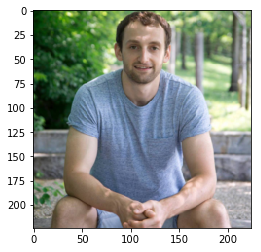

In [144]:
content_image = Variable(U.get_image(3, None))
print(content_image.size())
U.imshow(content_image.data)

torch.Size([3, 224, 224])


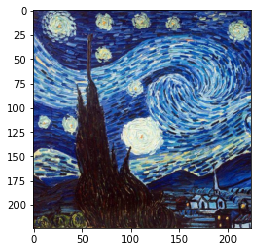

In [145]:
style_image = Variable(U.get_image(5, None, 112))
print(style_image.size())
U.imshow(style_image.data)

In [146]:

#all conv indexes [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]
selected_convolutional_indexes = [21, 24]
selected_style_indexes = [2, 7, 12, 19, 26, 28]

content_weights = {
    21: 0.15,
    24: 0.15,
}
style_weights = {
    2: 0.05,
    7: 0.15,
    12: 0.20,
    19: 0.20,
    26: 0.25,
    28: 0.35,    
}

class ContentLoss(nn.Module):
    def __init__(self, weight, target):
        super(ContentLoss, self).__init__()        
        #why detach?
        self.target = target.detach()
        self.weight = weight
        self.loss_fn = nn.MSELoss()
    
    def forward(self, input):
        ab = input.clone()
        #why do we have to clone here? Without it, I get 'an input required for gradient has been modified in place'
        content_loss = self.loss_fn(input, self.target)
        self.loss = content_loss
        self.output = ab
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss
        
class GramMatrix(nn.Module):
    def forward(self, input):
        batch_size = input.size()[0]
        height  = input.size()[1]
        width = input.size()[2]
        chan = input.size()[3]
        #view vs resize here? view used in tutorial
        flattened_channels = input.resize(batch_size, chan, width * height)
        g_matrix =         g_matrix = flattened_channels[0].matmul(flattened_channels[0].t()).unsqueeze(0)
        print("Number elements: {}".format(flattened_channels.nelement()))
        print(g_matrix)
        return g_matrix / flattened_channels.nelement())

class StyleLoss(nn.Module):
    def __init__(self, weight, target):
        super(StyleLoss, self).__init__()           
        self.weight = weight
        self.gram = GramMatrix()
        self.target_gram = self.gram(target).detach()
        self.loss_fn = nn.MSELoss()
    
    def forward(self, input):
        cloned_input = input.clone()
        self.loss = self.loss_fn(self.gram(input), self.target_gram)
        self.output = cloned_input
        return self.output
    
    def backward(self, retain_graph=True):
        #why retain variables here?
        self.loss.backward(retain_graph=retain_graph)
        return self.loss
        
def build_model(cnn):
    content_losses = []
    style_losses = []
    model = nn.Sequential()
    cnn = copy.deepcopy(cnn)
    #purpose of deepcopy here?
    vgg_avg_module_list = U.convert_to_average_pooling(cnn.features)    
    #cnn = copy.deepcopy(cnn) ????
    for index, layer in enumerate(vgg_avg_module_list):
        #what happens when indexes overlap and module is added twice?

        layer_set = False
        if type(layer) is nn.modules.conv.Conv2d and index in selected_style_indexes:
            layer_set = True
            model.add_module("layer_{}".format(index), layer)
            style_target = model(style_image.unsqueeze(0))
            style_loss = StyleLoss(style_weights[index], style_target)
            style_losses.append(style_loss)
            model.add_module("layer_{}_loss".format(index), style_loss)
            
        if type(layer) is nn.modules.conv.Conv2d and index in selected_convolutional_indexes:
            layer_set = True   
            model.add_module("layer_{}".format(index), layer)
            content_target = model(content_image.unsqueeze(0))
            content_loss = ContentLoss(content_weights[index], content_target)
            content_losses.append(content_loss)
            model.add_module("layer_{}_loss".format(index), content_loss)
        if not layer_set:
            model.add_module("layer_{}".format(index), layer)
    return model, content_losses, style_losses

In [147]:
model, c_losses, s_losses = build_model(vgg)

In [148]:
class Runner():
    def __init__(self, model, c_losses, s_losses, size):
        self.model = model
        self.c_losses = c_losses
        self.s_losses = s_losses
        self.size = size
        self.count = 0

    def loss_fn(self, flattened_image):
        self.count += 1
        predicted_image = torch.Tensor(flattened_image.reshape(self.size))
        prediction = nn.Parameter(predicted_image)
        
        
        model(prediction.unsqueeze(0))
        
        
        s_loss = sum([ s.backward() for s in self.s_losses ])
        c_loss = sum([ c.backward() for c in self.c_losses ])       
        total_loss = (s_loss + c_loss).data.numpy().astype(np.float64)

        gradients = prediction.grad.data.numpy().flatten().astype(np.float64)
        if self.count % 5 == 0:
            print("s_loss ", s_loss.data.numpy()[0])
            print("c_loss ", c_loss.data.numpy()[0])
        model.zero_grad()
        return  total_loss,  gradients


In [149]:
from scipy.optimize import fmin_l_bfgs_b 
noise_tensor = torch.rand(3,224, 224) - 0.5
gen_image = noise_tensor.numpy().flatten()

runner = Runner(model, c_losses, s_losses, content_image.size())
for i in range(2):
    generated_image, min_val, y = fmin_l_bfgs_b(runner.loss_fn, gen_image, maxfun=10)
    print("Epoch "+str(i) + " Loss: " +str(min_val))
    gen_image = generated_image

s_loss  0.0160942
c_loss  6.65349
s_loss  0.0091571
c_loss  5.19167
Epoch 0 Loss: [ 4.80729914]
s_loss  0.00989014
c_loss  3.83813
s_loss  0.0163808
c_loss  2.45551
Epoch 1 Loss: [ 2.12500882]


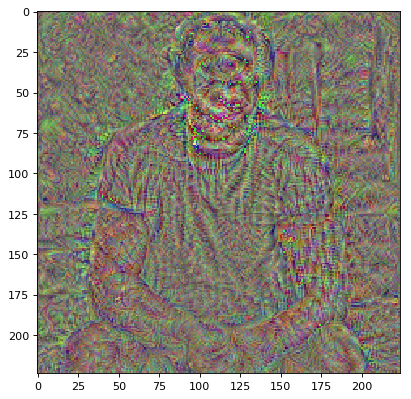

In [151]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(gen_image.reshape(content_image.size())))

## Style Loss

### Style Image

torch.Size([3, 224, 224])


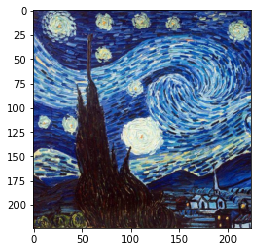

In [7]:
#all conv indexes [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]

module_lists = [list(vgg.features.children())[:index+1] for index in  selected_convolutional_indexes]
conv_layer_models = [ U.convert_to_average_pooling(modules) for modules in module_lists ]
[ freeze_model(m) for m in conv_layer_models]

[None, None, None, None, None, None]

In [8]:
def gram_matrix(x):

    return g_matrix

def style_loss(model, prediction, style_image_layer, weight):
    pred = model.forward(prediction.unsqueeze(0))
    target = model.forward(style_image_layer.unsqueeze(0))
    return weight * mse(gram_matrix(pred), gram_matrix(target))  / pred.nelement()

model_weights = [0.02, 0.2, 0.2,0.25, 0.3]
def style_loss_and_gradients(gen_image, style_image):
    style_image = Variable(style_image, requires_grad = False)
    return sum([style_loss(model, gen_image, style_image, weight) for model, weight in zip(conv_layer_models, model_weights) ])

# Minimize noise based on vgg output

In [9]:
from scipy.optimize import fmin_l_bfgs_b 

In [70]:
class StyleTransfer():
    def __init__(self, style_image, content_image):
        self.style_image = style_image
        self.content_image = content_image
        self.count = 0 
        self.gradient_mag_diff = 1
                
    def loss_fn(self, flattened_image):


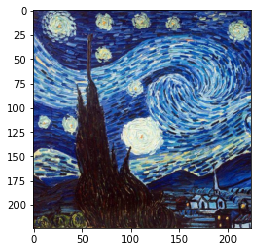

In [27]:
U.imshow(style_image)

In [28]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 1, noise_tensor)

('s_loss ', 1397.0364)
('c_loss ', 11.784041)
('Content weights', 1)
('s_loss ', 720.46924)
('c_loss ', 12.216908)
('Content weights', 1)
('s_loss ', 346.4538)
('c_loss ', 12.367077)
('Content weights', 1)
('s_loss ', 210.42143)
('c_loss ', 12.846599)
('Content weights', 1)
Epoch 0 Loss: [ 195.47651672]


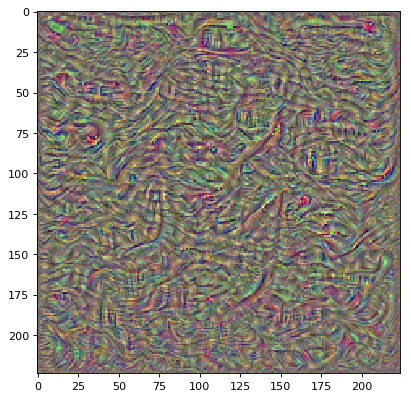

In [29]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [30]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 3, torch.Tensor(result))

('s_loss ', 160.65895)
('c_loss ', 12.674891)
('Content weights', 1)
('s_loss ', 107.33267)
('c_loss ', 12.388838)
('Content weights', 1)
('s_loss ', 86.463394)
('c_loss ', 12.189594)
('Content weights', 1)
('s_loss ', 69.131355)
('c_loss ', 11.945432)
('Content weights', 1)
Epoch 0 Loss: [ 79.18061829]
('s_loss ', 65.885193)
('c_loss ', 11.981701)
('Content weights', 1)
('s_loss ', 54.919102)
('c_loss ', 11.900654)
('Content weights', 1)
('s_loss ', 47.832287)
('c_loss ', 11.729154)
('Content weights', 1)
('s_loss ', 41.480671)
('c_loss ', 11.446129)
('Content weights', 1)
Epoch 1 Loss: [ 49.90190506]
('s_loss ', 38.294632)
('c_loss ', 11.358334)
('Content weights', 1)
('s_loss ', 33.762878)
('c_loss ', 11.340592)
('Content weights', 1)
('s_loss ', 29.312508)
('c_loss ', 11.003752)
('Content weights', 1)
('s_loss ', 26.950497)
('c_loss ', 10.965229)
('Content weights', 1)
Epoch 2 Loss: [ 35.6292305]


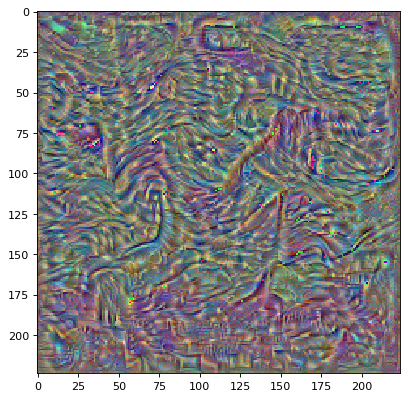

In [31]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [33]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 3, torch.Tensor(result))

('s_loss ', 24.453415)
('c_loss ', 10.748853)
('Content weights', 1)
('s_loss ', 21.294359)
('c_loss ', 11.03967)
('Content weights', 1)
('s_loss ', 19.321751)
('c_loss ', 11.430994)
('Content weights', 1)
('s_loss ', 17.733456)
('c_loss ', 11.630966)
('Content weights', 1)
Epoch 0 Loss: [ 1767.79345703]
('s_loss ', 17.48167)
('c_loss ', 11.627021)
('Content weights', 1)
('s_loss ', 16.212635)
('c_loss ', 11.550195)
('Content weights', 1)
('s_loss ', 14.843453)
('c_loss ', 11.413992)
('Content weights', 1)
('s_loss ', 14.114832)
('c_loss ', 11.383058)
('Content weights', 1)
Epoch 1 Loss: [ 1381.97119141]
('s_loss ', 13.593521)
('c_loss ', 11.396916)
('Content weights', 1)
('s_loss ', 13.083549)
('c_loss ', 11.443997)
('Content weights', 1)
('s_loss ', 12.354368)
('c_loss ', 11.573376)
('Content weights', 1)
('s_loss ', 11.531358)
('c_loss ', 11.702685)
('Content weights', 1)
Epoch 2 Loss: [ 1153.11694336]


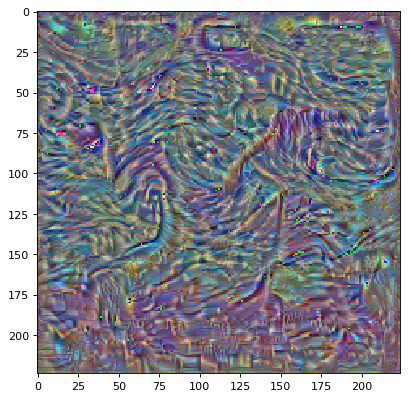

In [34]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [35]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 3, torch.Tensor(result))

('s_loss ', 11.375447)
('c_loss ', 11.727314)
('Content weights', 1)
('s_loss ', 10.56647)
('c_loss ', 11.618845)
('Content weights', 1)
('s_loss ', 9.9650526)
('c_loss ', 11.576334)
('Content weights', 1)
('s_loss ', 9.1450949)
('c_loss ', 11.586689)
('Content weights', 1)
Epoch 0 Loss: [ 889.76715088]
('s_loss ', 8.7503471)
('c_loss ', 11.631339)
('Content weights', 1)
('s_loss ', 8.2225666)
('c_loss ', 11.636959)
('Content weights', 1)
('s_loss ', 7.7373967)
('c_loss ', 11.720011)
('Content weights', 1)
('s_loss ', 7.2165966)
('c_loss ', 11.760608)
('Content weights', 1)
Epoch 1 Loss: [ 717.91333008]
('s_loss ', 7.0525708)
('c_loss ', 11.782791)
('Content weights', 1)
('s_loss ', 6.8312016)
('c_loss ', 11.76775)
('Content weights', 1)
('s_loss ', 6.4952087)
('c_loss ', 11.736056)
('Content weights', 1)
('s_loss ', 6.1786265)
('c_loss ', 11.695213)
('Content weights', 1)
Epoch 2 Loss: [ 608.97576904]


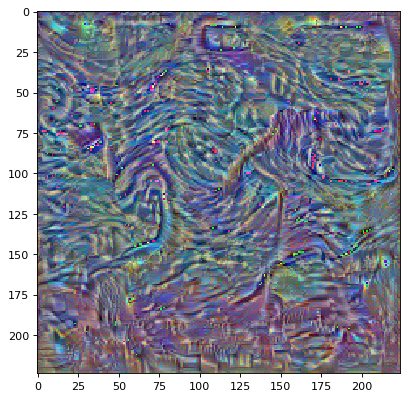

In [36]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [37]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 3, torch.Tensor(result))

('s_loss ', 5.944768)
('c_loss ', 11.681901)
('Content weights', 1)
('s_loss ', 5.6151586)
('c_loss ', 11.733296)
('Content weights', 1)
('s_loss ', 5.3687987)
('c_loss ', 11.772583)
('Content weights', 1)
('s_loss ', 5.2474174)
('c_loss ', 11.794267)
('Content weights', 1)
Epoch 0 Loss: [ 532.23748779]
('s_loss ', 5.1877823)
('c_loss ', 11.789011)
('Content weights', 1)
('s_loss ', 5.0362878)
('c_loss ', 11.773313)
('Content weights', 1)
('s_loss ', 4.816227)
('c_loss ', 11.741637)
('Content weights', 1)
('s_loss ', 4.6178098)
('c_loss ', 11.715251)
('Content weights', 1)
Epoch 1 Loss: [ 459.25408936]
('s_loss ', 4.4708471)
('c_loss ', 11.702706)
('Content weights', 1)
('s_loss ', 4.3176451)
('c_loss ', 11.723825)
('Content weights', 1)
('s_loss ', 4.1584868)
('c_loss ', 11.754756)
('Content weights', 1)
('s_loss ', 3.9955392)
('c_loss ', 11.785131)
('Content weights', 1)
Epoch 2 Loss: [ 407.67459106]


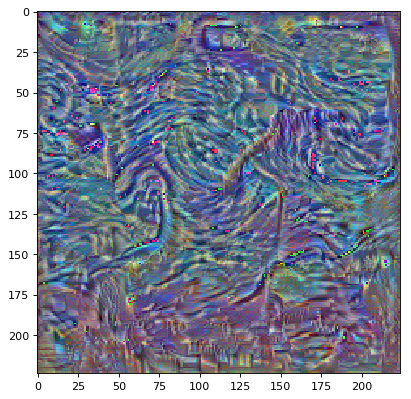

In [38]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [39]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 3, torch.Tensor(result))

('s_loss ', 3.9434392)
('c_loss ', 11.787151)
('Content weights', 1)
('s_loss ', 3.7838488)
('c_loss ', 11.753243)
('Content weights', 1)
('s_loss ', 3.6604946)
('c_loss ', 11.747456)
('Content weights', 1)
('s_loss ', 3.604918)
('c_loss ', 11.741704)
('Content weights', 1)
Epoch 0 Loss: [ 367.93185425]
('s_loss ', 3.5583448)
('c_loss ', 11.735668)
('Content weights', 1)
('s_loss ', 3.4311399)
('c_loss ', 11.754047)
('Content weights', 1)
('s_loss ', 3.2892427)
('c_loss ', 11.770049)
('Content weights', 1)
('s_loss ', 3.227823)
('c_loss ', 11.791877)
('Content weights', 1)
Epoch 1 Loss: [ 330.84481812]
('s_loss ', 3.188117)
('c_loss ', 11.792144)
('Content weights', 1)
('s_loss ', 3.0735111)
('c_loss ', 11.768258)
('Content weights', 1)
('s_loss ', 2.9624708)
('c_loss ', 11.759661)
('Content weights', 1)
('s_loss ', 2.9103358)
('c_loss ', 11.744967)
('Content weights', 1)
Epoch 2 Loss: [ 290.46234131]


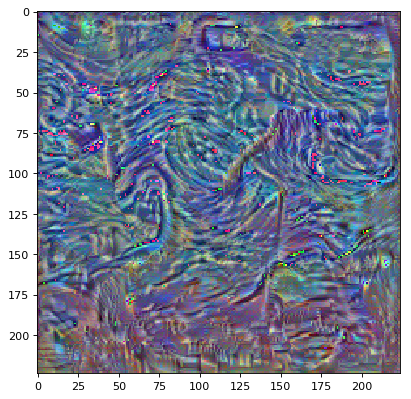

In [40]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [41]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 3, torch.Tensor(result))

('s_loss ', 2.7722826)
('c_loss ', 11.732232)
('Content weights', 1)
('s_loss ', 2.6335866)
('c_loss ', 11.761984)
('Content weights', 1)
('s_loss ', 2.5450237)
('c_loss ', 11.779659)
('Content weights', 1)
('s_loss ', 2.5042336)
('c_loss ', 11.786682)
('Content weights', 1)
Epoch 0 Loss: [ 258.94638062]
('s_loss ', 2.4588258)
('c_loss ', 11.786958)
('Content weights', 1)
('s_loss ', 2.4295361)
('c_loss ', 11.774825)
('Content weights', 1)
('s_loss ', 2.3659863)
('c_loss ', 11.759083)
('Content weights', 1)
('s_loss ', 2.318073)
('c_loss ', 11.752379)
('Content weights', 1)
Epoch 1 Loss: [ 242.1056366]
('s_loss ', 2.3018448)
('c_loss ', 11.755095)
('Content weights', 1)
('s_loss ', 2.2724185)
('c_loss ', 11.751423)
('Content weights', 1)
('s_loss ', 2.1739163)
('c_loss ', 11.784386)
('Content weights', 1)
('s_loss ', 2.1405988)
('c_loss ', 11.779196)
('Content weights', 1)
Epoch 2 Loss: [ 219.03182983]


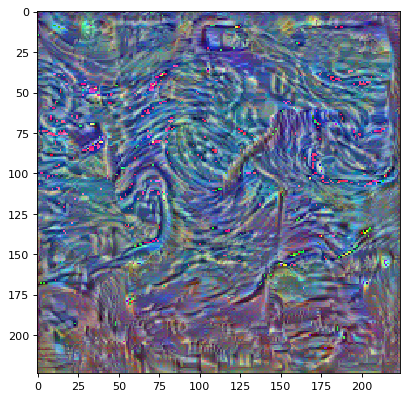

In [42]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [43]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 3, torch.Tensor(result))

('s_loss ', 2.0612626)
('c_loss ', 11.779741)
('Content weights', 1)
('s_loss ', 1.9678234)
('c_loss ', 11.779907)
('Content weights', 1)
('s_loss ', 1.9142838)
('c_loss ', 11.774977)
('Content weights', 1)
('s_loss ', 1.8897328)
('c_loss ', 11.766797)
('Content weights', 1)
Epoch 0 Loss: [ 198.97727966]
('s_loss ', 1.8705866)
('c_loss ', 11.759265)
('Content weights', 1)
('s_loss ', 1.8389333)
('c_loss ', 11.769435)
('Content weights', 1)
('s_loss ', 1.7813302)
('c_loss ', 11.779928)
('Content weights', 1)
('s_loss ', 1.7576976)
('c_loss ', 11.780084)
('Content weights', 1)
Epoch 1 Loss: [ 183.37406921]
('s_loss ', 1.7147375)
('c_loss ', 11.786093)
('Content weights', 1)
('s_loss ', 1.6644032)
('c_loss ', 11.781109)
('Content weights', 1)
('s_loss ', 1.6227829)
('c_loss ', 11.777878)
('Content weights', 1)
('s_loss ', 1.60982)
('c_loss ', 11.775914)
('Content weights', 1)
Epoch 2 Loss: [ 171.51625061]


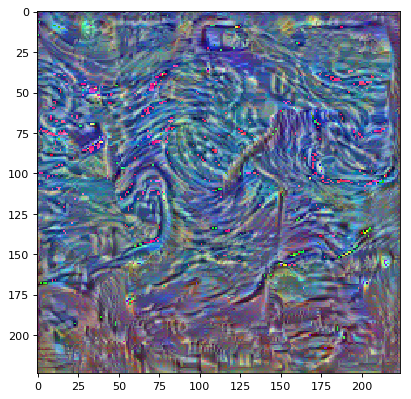

In [44]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 1.5949657)
('c_loss ', 11.768936)
('Content weights', 1)
('s_loss ', 1.5796123)
('c_loss ', 11.770787)
('Content weights', 1)
('s_loss ', 1.5430431)
('c_loss ', 11.778364)
('Content weights', 1)
('s_loss ', 1.5209284)
('c_loss ', 11.780848)
('Content weights', 1)
Epoch 0 Loss: [ 163.57118225]
('s_loss ', 1.5169908)
('c_loss ', 11.781619)
('Content weights', 1)
('s_loss ', 1.4894369)
('c_loss ', 11.770431)
('Content weights', 1)
('s_loss ', 1.4623759)
('c_loss ', 11.771337)
('Content weights', 1)
('s_loss ', 1.4537776)
('c_loss ', 11.764827)
('Content weights', 1)
Epoch 1 Loss: [ 155.32546997]
('s_loss ', 1.4348907)
('c_loss ', 11.756449)
('Content weights', 1)
('s_loss ', 1.4205596)
('c_loss ', 11.762456)
('Content weights', 1)
('s_loss ', 1.3917955)
('c_loss ', 11.770261)
('Content weights', 1)
('s_loss ', 1.3744981)
('c_loss ', 11.771062)
('Content weights', 1)
Epoch 2 Loss: [ 148.08610535]


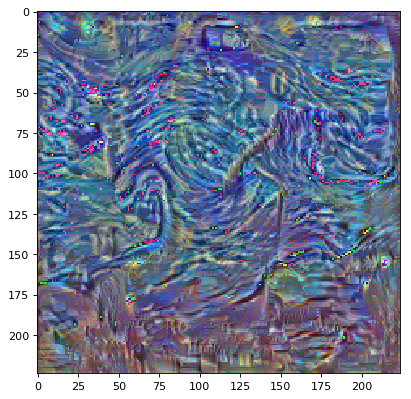

In [45]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 3, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 1.3516997)
('c_loss ', 11.771832)
('Content weights', 1)
('s_loss ', 1.3317192)
('c_loss ', 11.764224)
('Content weights', 1)
('s_loss ', 1.318646)
('c_loss ', 11.764106)
('Content weights', 1)
('s_loss ', 1.3096704)
('c_loss ', 11.757976)
('Content weights', 1)
Epoch 0 Loss: [ 142.39961243]
('s_loss ', 1.3031927)
('c_loss ', 11.75749)
('Content weights', 1)
('s_loss ', 1.2953205)
('c_loss ', 11.760645)
('Content weights', 1)
('s_loss ', 1.3156881)
('c_loss ', 11.765812)
('Content weights', 1)
('s_loss ', 1.2749634)
('c_loss ', 11.764778)
('Content weights', 1)
Epoch 1 Loss: [ 138.37097168]
('s_loss ', 1.2658542)
('c_loss ', 11.766373)
('Content weights', 1)
('s_loss ', 1.2541565)
('c_loss ', 11.761136)
('Content weights', 1)
('s_loss ', 1.2396585)
('c_loss ', 11.75842)
('Content weights', 1)
('s_loss ', 1.2330205)
('c_loss ', 11.754491)
('Content weights', 1)
Epoch 2 Loss: [ 134.1991272]


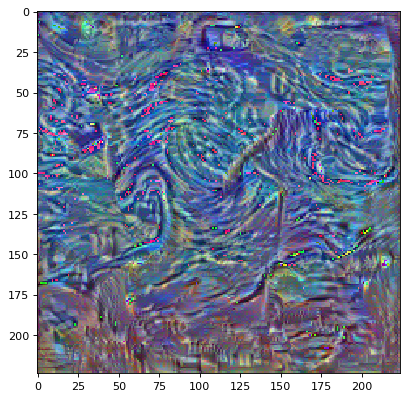

In [46]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 3, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 1.2215114)
('c_loss ', 11.752959)
('Content weights', 1)
('s_loss ', 1.2131317)
('c_loss ', 11.754841)
('Content weights', 1)
('s_loss ', 1.198481)
('c_loss ', 11.757456)
('Content weights', 1)
('s_loss ', 1.1894774)
('c_loss ', 11.759086)
('Content weights', 1)
Epoch 0 Loss: [ 130.48629761]
('s_loss ', 1.1866543)
('c_loss ', 11.758764)
('Content weights', 1)
('s_loss ', 1.1791452)
('c_loss ', 11.751676)
('Content weights', 1)
('s_loss ', 1.1641401)
('c_loss ', 11.751933)
('Content weights', 1)
('s_loss ', 1.1601177)
('c_loss ', 11.748235)
('Content weights', 1)
Epoch 1 Loss: [ 127.40102386]
('s_loss ', 1.1563574)
('c_loss ', 11.748414)
('Content weights', 1)
('s_loss ', 1.1523616)
('c_loss ', 11.748303)
('Content weights', 1)
('s_loss ', 1.1404346)
('c_loss ', 11.748484)
('Content weights', 1)
('s_loss ', 1.1308316)
('c_loss ', 11.751437)
('Content weights', 1)
Epoch 2 Loss: [ 124.50956726]


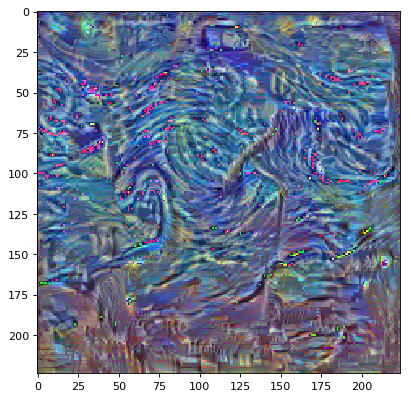

In [47]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 3, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 1.1268198)
('c_loss ', 11.750703)
('Content weights', 1)
('s_loss ', 1.1160107)
('c_loss ', 11.745809)
('Content weights', 1)
('s_loss ', 1.1065533)
('c_loss ', 11.741495)
('Content weights', 1)
('s_loss ', 1.1018087)
('c_loss ', 11.740978)
('Content weights', 1)
Epoch 0 Loss: [ 121.70030975]
('s_loss ', 1.0983655)
('c_loss ', 11.740564)
('Content weights', 1)
('s_loss ', 1.0914056)
('c_loss ', 11.740137)
('Content weights', 1)
('s_loss ', 1.1541362)
('c_loss ', 11.734118)
('Content weights', 1)
('s_loss ', 1.0707355)
('c_loss ', 11.743964)
('Content weights', 1)
Epoch 1 Loss: [ 118.13674164]
('s_loss ', 1.0625988)
('c_loss ', 11.741684)
('Content weights', 1)
('s_loss ', 1.0538654)
('c_loss ', 11.739234)
('Content weights', 1)
('s_loss ', 1.0401982)
('c_loss ', 11.733382)
('Content weights', 1)
('s_loss ', 1.035931)
('c_loss ', 11.730732)
('Content weights', 1)
Epoch 2 Loss: [ 113.84825897]
('s_loss ', 3.0151286)
('c_loss ', 11.782935)
('Content weights', 1)
('s_loss ', 1.

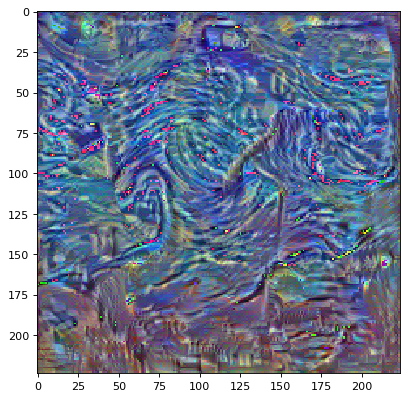

In [48]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 5, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 0.97008085)
('c_loss ', 11.721379)
('Content weights', 1)
('s_loss ', 0.9626683)
('c_loss ', 11.724475)
('Content weights', 1)
('s_loss ', 0.95569807)
('c_loss ', 11.723275)
('Content weights', 1)
('s_loss ', 0.95186967)
('c_loss ', 11.721175)
('Content weights', 1)
Epoch 0 Loss: [ 106.62625122]
('s_loss ', 0.9487468)
('c_loss ', 11.720955)
('Content weights', 1)
('s_loss ', 0.94454944)
('c_loss ', 11.721879)
('Content weights', 1)
('s_loss ', 0.93804675)
('c_loss ', 11.719681)
('Content weights', 1)
('s_loss ', 0.93226182)
('c_loss ', 11.716759)
('Content weights', 1)
Epoch 1 Loss: [ 104.80891418]
('s_loss ', 0.93085402)
('c_loss ', 11.715296)
('Content weights', 1)
('s_loss ', 0.92695427)
('c_loss ', 11.714311)
('Content weights', 1)
('s_loss ', 0.91875786)
('c_loss ', 11.717077)
('Content weights', 1)
('s_loss ', 0.91656005)
('c_loss ', 11.717676)
('Content weights', 1)
Epoch 2 Loss: [ 102.74265289]
('s_loss ', 0.91030049)
('c_loss ', 11.712603)
('Content weights', 1)
('

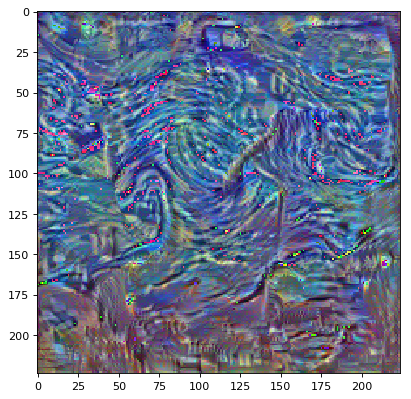

In [49]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 5, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 0.8649419)
('c_loss ', 11.704102)
('Content weights', 1)
('s_loss ', 0.8611061)
('c_loss ', 11.7023)
('Content weights', 1)
('s_loss ', 0.86679429)
('c_loss ', 11.707558)
('Content weights', 1)
('s_loss ', 0.84744805)
('c_loss ', 11.700618)
('Content weights', 1)
Epoch 0 Loss: [ 96.01574707]
('s_loss ', 0.8427186)
('c_loss ', 11.695098)
('Content weights', 1)
('s_loss ', 0.83507115)
('c_loss ', 11.696757)
('Content weights', 1)
('s_loss ', 0.82728136)
('c_loss ', 11.696331)
('Content weights', 1)
('s_loss ', 0.82424164)
('c_loss ', 11.694579)
('Content weights', 1)
Epoch 1 Loss: [ 93.95494843]
('s_loss ', 0.82256567)
('c_loss ', 11.694473)
('Content weights', 1)
('s_loss ', 0.82042611)
('c_loss ', 11.693145)
('Content weights', 1)
('s_loss ', 0.81484103)
('c_loss ', 11.692391)
('Content weights', 1)
('s_loss ', 0.81315535)
('c_loss ', 11.691492)
('Content weights', 1)
Epoch 2 Loss: [ 92.88195038]
('s_loss ', 2.0094476)
('c_loss ', 11.635494)
('Content weights', 1)
('s_loss 

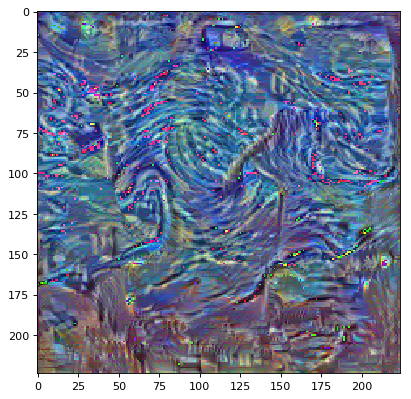

In [50]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 5, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 0.78575444)
('c_loss ', 11.68232)
('Content weights', 1)
('s_loss ', 0.78415704)
('c_loss ', 11.683983)
('Content weights', 1)
('s_loss ', 0.77996993)
('c_loss ', 11.685501)
('Content weights', 1)
('s_loss ', 0.77682585)
('c_loss ', 11.679996)
('Content weights', 1)
Epoch 0 Loss: [ 89.29603577]
('s_loss ', 0.77601403)
('c_loss ', 11.679137)
('Content weights', 1)
('s_loss ', 0.77033854)
('c_loss ', 11.682886)
('Content weights', 1)
('s_loss ', 0.7657668)
('c_loss ', 11.677471)
('Content weights', 1)
('s_loss ', 0.76402628)
('c_loss ', 11.678406)
('Content weights', 1)
Epoch 1 Loss: [ 87.71237946]
('s_loss ', 0.75977701)
('c_loss ', 11.678448)
('Content weights', 1)
('s_loss ', 0.75678939)
('c_loss ', 11.674776)
('Content weights', 1)
('s_loss ', 0.75451332)
('c_loss ', 11.677279)
('Content weights', 1)
('s_loss ', 0.75286072)
('c_loss ', 11.67826)
('Content weights', 1)
Epoch 2 Loss: [ 86.7861557]
('s_loss ', 0.75108171)
('c_loss ', 11.677987)
('Content weights', 1)
('s_los

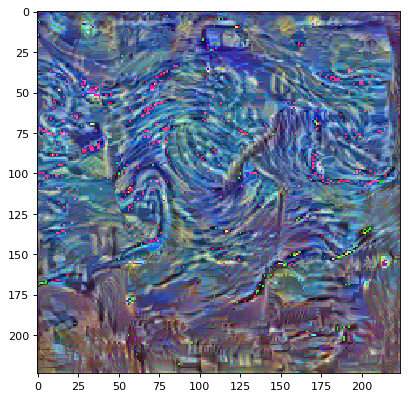

In [51]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 5, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 0.72038084)
('c_loss ', 11.670342)
('Content weights', 1)
('s_loss ', 0.71612322)
('c_loss ', 11.668599)
('Content weights', 1)
('s_loss ', 0.72493273)
('c_loss ', 11.67054)
('Content weights', 1)
('s_loss ', 0.7087419)
('c_loss ', 11.66681)
('Content weights', 1)
Epoch 0 Loss: [ 82.38009644]
('s_loss ', 0.70700884)
('c_loss ', 11.665825)
('Content weights', 1)
('s_loss ', 0.70398122)
('c_loss ', 11.665954)
('Content weights', 1)
('s_loss ', 0.69917393)
('c_loss ', 11.663256)
('Content weights', 1)
('s_loss ', 0.69764984)
('c_loss ', 11.663127)
('Content weights', 1)
Epoch 1 Loss: [ 81.13148499]
('s_loss ', 0.69460344)
('c_loss ', 11.662752)
('Content weights', 1)
('s_loss ', 0.69176126)
('c_loss ', 11.661258)
('Content weights', 1)
('s_loss ', 0.68682432)
('c_loss ', 11.661056)
('Content weights', 1)
('s_loss ', 0.68548381)
('c_loss ', 11.660812)
('Content weights', 1)
Epoch 2 Loss: [ 80.11421204]
('s_loss ', 2.0120828)
('c_loss ', 11.684668)
('Content weights', 1)
('s_los

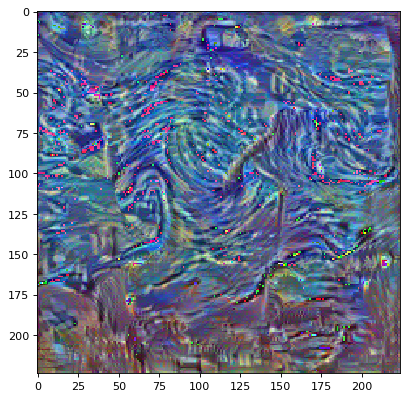

In [52]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 5, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 0.66614431)
('c_loss ', 11.65643)
('Content weights', 1)
('s_loss ', 0.6622237)
('c_loss ', 11.653632)
('Content weights', 1)
('s_loss ', 0.66969162)
('c_loss ', 11.648663)
('Content weights', 1)
('s_loss ', 0.65720624)
('c_loss ', 11.65226)
('Content weights', 1)
Epoch 0 Loss: [ 77.29867554]
('s_loss ', 0.65637624)
('c_loss ', 11.651954)
('Content weights', 1)
('s_loss ', 0.65478724)
('c_loss ', 11.652385)
('Content weights', 1)
('s_loss ', 0.6887362)
('c_loss ', 11.643395)
('Content weights', 1)
('s_loss ', 0.65012193)
('c_loss ', 11.649983)
('Content weights', 1)
Epoch 1 Loss: [ 76.56520844]
('s_loss ', 0.64901012)
('c_loss ', 11.650662)
('Content weights', 1)
('s_loss ', 0.64769828)
('c_loss ', 11.648426)
('Content weights', 1)
('s_loss ', 0.64613312)
('c_loss ', 11.648959)
('Content weights', 1)
('s_loss ', 0.64519662)
('c_loss ', 11.649068)
('Content weights', 1)
Epoch 2 Loss: [ 76.09169006]
('s_loss ', 7.6205812)
('c_loss ', 11.742348)
('Content weights', 1)
('s_loss

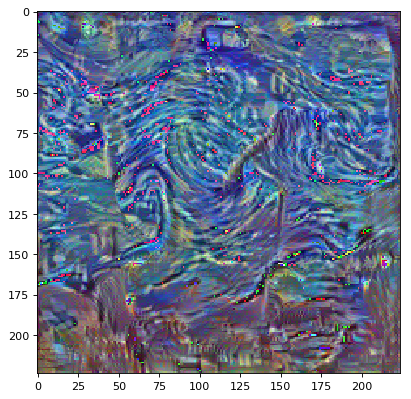

In [53]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 5, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 0.6064294)
('c_loss ', 11.630815)
('Content weights', 1)
('s_loss ', 0.60812116)
('c_loss ', 11.561073)
('Content weights', 1)
('s_loss ', 0.61415195)
('c_loss ', 11.425321)
('Content weights', 1)
('s_loss ', 0.61646116)
('c_loss ', 11.361441)
('Content weights', 1)
Epoch 0 Loss: [ 17.50814438]
('s_loss ', 0.61630028)
('c_loss ', 11.339425)
('Content weights', 1)
('s_loss ', 0.61295795)
('c_loss ', 11.341427)
('Content weights', 1)
('s_loss ', 0.60614425)
('c_loss ', 11.350795)
('Content weights', 1)
('s_loss ', 0.60600281)
('c_loss ', 11.327765)
('Content weights', 1)
Epoch 1 Loss: [ 17.35420418]
('s_loss ', 0.60449874)
('c_loss ', 11.30821)
('Content weights', 1)
('s_loss ', 0.60335439)
('c_loss ', 11.29259)
('Content weights', 1)
('s_loss ', 0.60518867)
('c_loss ', 11.21315)
('Content weights', 1)
('s_loss ', 0.60623085)
('c_loss ', 11.183174)
('Content weights', 1)
Epoch 2 Loss: [ 17.20905495]
('s_loss ', 6.0270567)
('c_loss ', 11.231074)
('Content weights', 1)
('s_loss

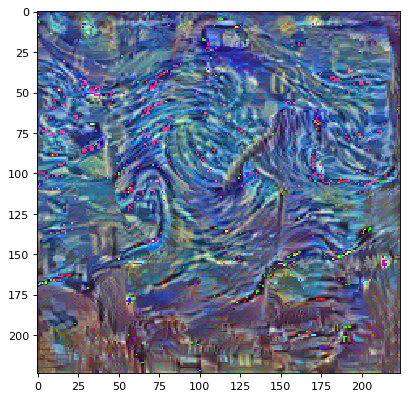

In [56]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 5, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 0.59536713)
('c_loss ', 11.019925)
('Content weights', 1)
('s_loss ', 0.5938468)
('c_loss ', 11.015703)
('Content weights', 1)
('s_loss ', 0.59028792)
('c_loss ', 11.00676)
('Content weights', 1)
('s_loss ', 0.59016991)
('c_loss ', 10.985832)
('Content weights', 1)
Epoch 0 Loss: [ 16.87247849]
('s_loss ', 0.58875179)
('c_loss ', 10.973014)
('Content weights', 1)
('s_loss ', 0.58731389)
('c_loss ', 10.957425)
('Content weights', 1)
('s_loss ', 0.69062322)
('c_loss ', 10.895196)
('Content weights', 1)
('s_loss ', 0.58780622)
('c_loss ', 10.90665)
('Content weights', 1)
Epoch 1 Loss: [ 16.76302719]
('s_loss ', 0.58773226)
('c_loss ', 10.88508)
('Content weights', 1)
('s_loss ', 0.58575898)
('c_loss ', 10.885898)
('Content weights', 1)
('s_loss ', 0.58156228)
('c_loss ', 10.88599)
('Content weights', 1)
('s_loss ', 0.58106732)
('c_loss ', 10.88143)
('Content weights', 1)
Epoch 2 Loss: [ 16.67021561]
('s_loss ', 1.4415388)
('c_loss ', 10.855684)
('Content weights', 1)
('s_loss '

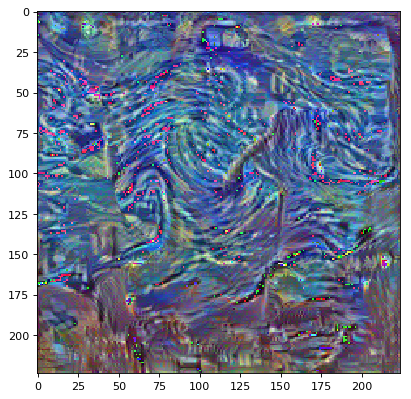

In [57]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 5, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 0.57514286)
('c_loss ', 10.658293)
('Content weights', 1)
('s_loss ', 0.56825525)
('c_loss ', 10.66418)
('Content weights', 1)
('s_loss ', 0.56438732)
('c_loss ', 10.658334)
('Content weights', 1)
('s_loss ', 0.56229007)
('c_loss ', 10.649513)
('Content weights', 1)
Epoch 0 Loss: [ 16.25835609]
('s_loss ', 0.56136984)
('c_loss ', 10.643383)
('Content weights', 1)
('s_loss ', 0.56016505)
('c_loss ', 10.636877)
('Content weights', 1)
('s_loss ', 0.55902827)
('c_loss ', 10.60647)
('Content weights', 1)
('s_loss ', 0.55908197)
('c_loss ', 10.583529)
('Content weights', 1)
Epoch 1 Loss: [ 16.15430832]
('s_loss ', 0.55918336)
('c_loss ', 10.561201)
('Content weights', 1)
('s_loss ', 0.55627048)
('c_loss ', 10.564167)
('Content weights', 1)
('s_loss ', 0.55340707)
('c_loss ', 10.561723)
('Content weights', 1)
('s_loss ', 0.55189699)
('c_loss ', 10.556839)
('Content weights', 1)
Epoch 2 Loss: [ 16.05464172]
('s_loss ', 0.55051208)
('c_loss ', 10.54952)
('Content weights', 1)
('s_lo

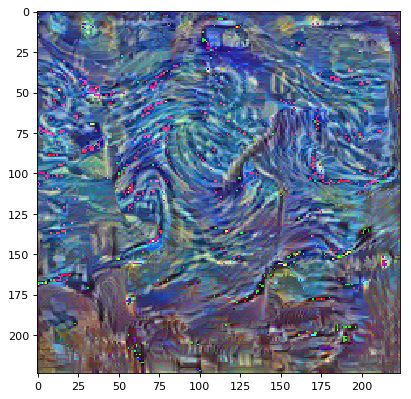

In [58]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 5, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 0.54213625)
('c_loss ', 10.474456)
('Content weights', 1)
('s_loss ', 0.54074234)
('c_loss ', 10.459836)
('Content weights', 1)
('s_loss ', 0.54027247)
('c_loss ', 10.443771)
('Content weights', 1)
('s_loss ', 0.5401265)
('c_loss ', 10.429924)
('Content weights', 1)
Epoch 0 Loss: [ 15.81960678]
('s_loss ', 0.54004085)
('c_loss ', 10.419274)
('Content weights', 1)
('s_loss ', 0.53814876)
('c_loss ', 10.420842)
('Content weights', 1)
('s_loss ', 0.53540564)
('c_loss ', 10.415997)
('Content weights', 1)
('s_loss ', 0.53426588)
('c_loss ', 10.406595)
('Content weights', 1)
Epoch 1 Loss: [ 15.74152756]
('s_loss ', 0.53382838)
('c_loss ', 10.402729)
('Content weights', 1)
('s_loss ', 0.53276575)
('c_loss ', 10.398047)
('Content weights', 1)
('s_loss ', 0.53197533)
('c_loss ', 10.369185)
('Content weights', 1)
('s_loss ', 0.53154558)
('c_loss ', 10.35968)
('Content weights', 1)
Epoch 2 Loss: [ 15.65890312]
('s_loss ', 2.1988325)
('c_loss ', 10.378036)
('Content weights', 1)
('s_lo

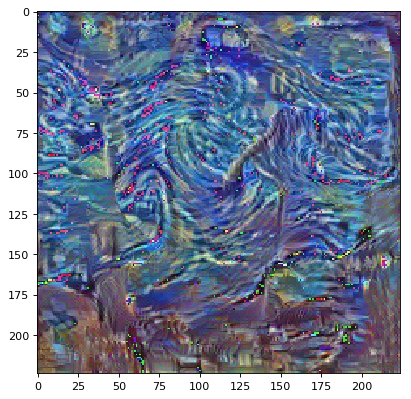

In [59]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 15, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 0.47974288)
('c_loss ', 9.9202261)
('Content weights', 1)
('s_loss ', 0.47722784)
('c_loss ', 9.9220715)
('Content weights', 1)
('s_loss ', 0.48402432)
('c_loss ', 9.9227428)
('Content weights', 1)
('s_loss ', 0.47483194)
('c_loss ', 9.9189711)
('Content weights', 1)
Epoch 0 Loss: [ 14.66342163]
('s_loss ', 0.47459939)
('c_loss ', 9.9168797)
('Content weights', 1)
('s_loss ', 0.47410527)
('c_loss ', 9.9119377)
('Content weights', 1)
('s_loss ', 0.47359461)
('c_loss ', 9.8930311)
('Content weights', 1)
('s_loss ', 0.47340363)
('c_loss ', 9.8836489)
('Content weights', 1)
Epoch 1 Loss: [ 14.58964062]
('s_loss ', 0.47250125)
('c_loss ', 9.8600435)
('Content weights', 1)
('s_loss ', 0.47057399)
('c_loss ', 9.8605404)
('Content weights', 1)
('s_loss ', 0.46855879)
('c_loss ', 9.8610106)
('Content weights', 1)
('s_loss ', 0.46765783)
('c_loss ', 9.8599606)
('Content weights', 1)
Epoch 2 Loss: [ 14.53225231]
('s_loss ', 0.46724805)
('c_loss ', 9.8597717)
('Content weights', 1)
('s

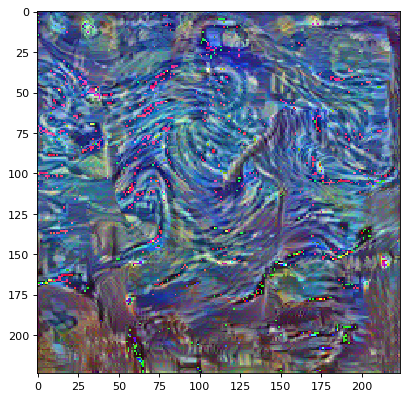

In [60]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 15, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 0.4167864)
('c_loss ', 9.4635954)
('Content weights', 1)
('s_loss ', 0.41630375)
('c_loss ', 9.4604769)
('Content weights', 1)
('s_loss ', 0.41734993)
('c_loss ', 9.4370642)
('Content weights', 1)
('s_loss ', 0.41528124)
('c_loss ', 9.4351139)
('Content weights', 1)
Epoch 0 Loss: [ 13.5757494]
('s_loss ', 0.41487303)
('c_loss ', 9.4258986)
('Content weights', 1)
('s_loss ', 0.41283605)
('c_loss ', 9.4247322)
('Content weights', 1)
('s_loss ', 0.41137818)
('c_loss ', 9.4160557)
('Content weights', 1)
('s_loss ', 0.41092288)
('c_loss ', 9.4125433)
('Content weights', 1)
Epoch 1 Loss: [ 13.51306629]
('s_loss ', 0.41054508)
('c_loss ', 9.4058867)
('Content weights', 1)
('s_loss ', 0.40976095)
('c_loss ', 9.4021931)
('Content weights', 1)
('s_loss ', 0.40877417)
('c_loss ', 9.3905048)
('Content weights', 1)
('s_loss ', 0.40863883)
('c_loss ', 9.3860788)
('Content weights', 1)
Epoch 2 Loss: [ 13.4708004]
('s_loss ', 7.5535889)
('c_loss ', 9.3486128)
('Content weights', 1)
('s_los

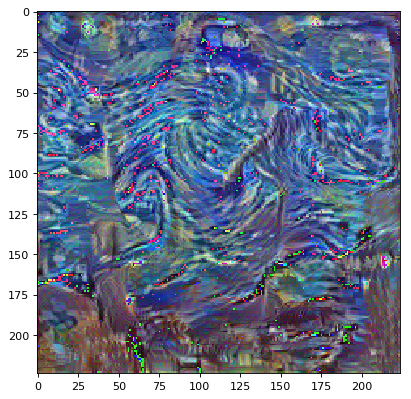

In [61]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 15, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 0.34021077)
('c_loss ', 8.7444019)
('Content weights', 1)
('s_loss ', 0.33986324)
('c_loss ', 8.7370806)
('Content weights', 1)
('s_loss ', 0.33967909)
('c_loss ', 8.7279348)
('Content weights', 1)
('s_loss ', 0.33930621)
('c_loss ', 8.7160444)
('Content weights', 1)
Epoch 0 Loss: [ 12.10177612]
('s_loss ', 0.3390367)
('c_loss ', 8.70819)
('Content weights', 1)
('s_loss ', 0.3376798)
('c_loss ', 8.7095013)
('Content weights', 1)
('s_loss ', 0.33636555)
('c_loss ', 8.7068224)
('Content weights', 1)
('s_loss ', 0.33603644)
('c_loss ', 8.7051821)
('Content weights', 1)
Epoch 1 Loss: [ 12.06306458]
('s_loss ', 0.33591506)
('c_loss ', 8.7037916)
('Content weights', 1)
('s_loss ', 0.33565953)
('c_loss ', 8.702424)
('Content weights', 1)
('s_loss ', 0.33530974)
('c_loss ', 8.6923313)
('Content weights', 1)
('s_loss ', 0.33516937)
('c_loss ', 8.6875868)
('Content weights', 1)
Epoch 2 Loss: [ 12.0337677]
('s_loss ', 2.3975315)
('c_loss ', 8.6621075)
('Content weights', 1)
('s_loss '

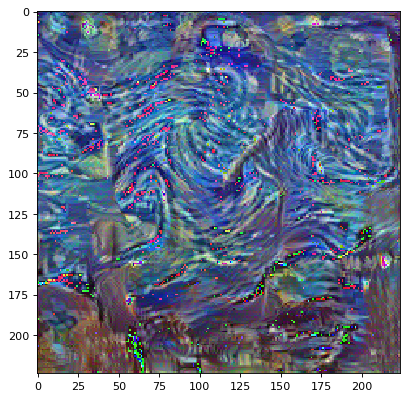

In [63]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 15, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 0.31442332)
('c_loss ', 8.5075321)
('Content weights', 1)
('s_loss ', 0.31366915)
('c_loss ', 8.5043287)
('Content weights', 1)
('s_loss ', 0.31341824)
('c_loss ', 8.5020494)
('Content weights', 1)
('s_loss ', 0.31313211)
('c_loss ', 8.4829597)
('Content weights', 1)
Epoch 0 Loss: [ 11.60271263]
('s_loss ', 0.31276512)
('c_loss ', 8.4736032)
('Content weights', 1)
('s_loss ', 0.3106944)
('c_loss ', 8.4743214)
('Content weights', 1)
('s_loss ', 0.31017122)
('c_loss ', 8.4728155)
('Content weights', 1)
('s_loss ', 0.30991757)
('c_loss ', 8.468852)
('Content weights', 1)
Epoch 1 Loss: [ 11.56391525]
('s_loss ', 0.30966467)
('c_loss ', 8.4669867)
('Content weights', 1)
('s_loss ', 0.30939558)
('c_loss ', 8.4660015)
('Content weights', 1)
('s_loss ', 0.30889174)
('c_loss ', 8.4609442)
('Content weights', 1)
('s_loss ', 0.30854297)
('c_loss ', 8.4583464)
('Content weights', 1)
Epoch 2 Loss: [ 11.53137398]
('s_loss ', 1.6597962)
('c_loss ', 8.4488087)
('Content weights', 1)
('s_lo

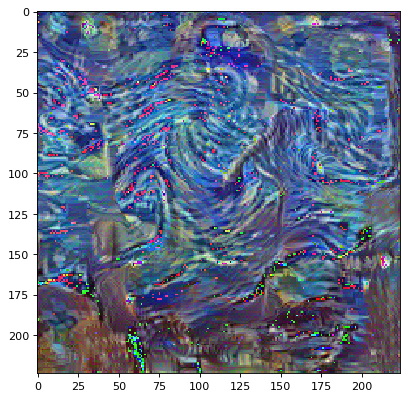

In [64]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 15, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 0.28871113)
('c_loss ', 8.2865162)
('Content weights', 1)
('s_loss ', 0.28797293)
('c_loss ', 8.2796869)
('Content weights', 1)
('s_loss ', 0.28739652)
('c_loss ', 8.2753754)
('Content weights', 1)
('s_loss ', 0.28728643)
('c_loss ', 8.27351)
('Content weights', 1)
Epoch 0 Loss: [ 11.14481163]
('s_loss ', 0.28718776)
('c_loss ', 8.2726355)
('Content weights', 1)
('s_loss ', 0.28672481)
('c_loss ', 8.2725048)
('Content weights', 1)
('s_loss ', 0.28622195)
('c_loss ', 8.2646275)
('Content weights', 1)
('s_loss ', 0.28583905)
('c_loss ', 8.2571106)
('Content weights', 1)
Epoch 1 Loss: [ 11.10172844]
('s_loss ', 0.28535777)
('c_loss ', 8.2472811)
('Content weights', 1)
('s_loss ', 0.28429648)
('c_loss ', 8.2426567)
('Content weights', 1)
('s_loss ', 0.28296593)
('c_loss ', 8.2390814)
('Content weights', 1)
('s_loss ', 0.28276315)
('c_loss ', 8.2364473)
('Content weights', 1)
Epoch 2 Loss: [ 11.06051159]
('s_loss ', 5.535728)
('c_loss ', 8.2330713)
('Content weights', 1)
('s_los

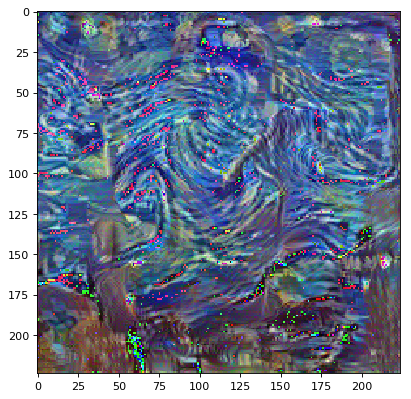

In [65]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 20, 15, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 2.8892844)
('c_loss ', 7.2466187)
('Content weights', 1)
('s_loss ', 4.9666104)
('c_loss ', 6.3572965)
('Content weights', 1)
Epoch 0 Loss: [ 67.4797821]
('s_loss ', 3.8740416)
('c_loss ', 6.3321905)
('Content weights', 1)
('s_loss ', 4.6458201)
('c_loss ', 5.7057848)
('Content weights', 1)
Epoch 1 Loss: [ 61.31613159]
('s_loss ', 4.3882985)
('c_loss ', 5.6664853)
('Content weights', 1)
('s_loss ', 4.0025892)
('c_loss ', 5.4484415)
('Content weights', 1)
Epoch 2 Loss: [ 57.22485352]


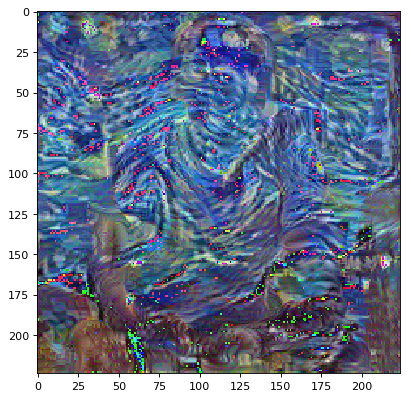

In [68]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 10, 3, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 12.922917)
('c_loss ', 5.5203853)
('Content weights', 1)
('s_loss ', 23.445606)
('c_loss ', 4.7400522)
('Content weights', 1)
Epoch 0 Loss: [ 250.98454285]
('s_loss ', 21.356525)
('c_loss ', 4.5559478)
('Content weights', 1)
('s_loss ', 26.519672)
('c_loss ', 4.0845065)
('Content weights', 1)
Epoch 1 Loss: [ 225.90423584]
('s_loss ', 22.800905)
('c_loss ', 3.9227061)
('Content weights', 1)
('s_loss ', 22.768766)
('c_loss ', 3.7275743)
('Content weights', 1)
Epoch 2 Loss: [ 201.27095032]


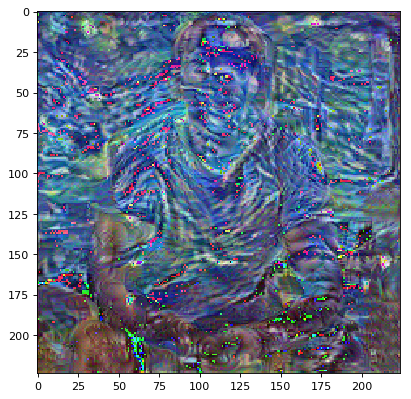

In [71]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 10, 3, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

('s_loss ', 26.024542)
('c_loss ', 3.4417257)
('Content weights', 1)
('s_loss ', 23.629393)
('c_loss ', 3.2929335)
('Content weights', 1)
Epoch 0 Loss: [ 186.03334045]
('s_loss ', 25.110502)
('c_loss ', 3.2005119)
('Content weights', 1)
('s_loss ', 24.950918)
('c_loss ', 3.096792)
('Content weights', 1)
Epoch 1 Loss: [ 177.78001404]
('s_loss ', 24.775507)
('c_loss ', 3.0517793)
('Content weights', 1)
('s_loss ', 25.487503)
('c_loss ', 2.9514747)
('Content weights', 1)
Epoch 2 Loss: [ 170.171875]


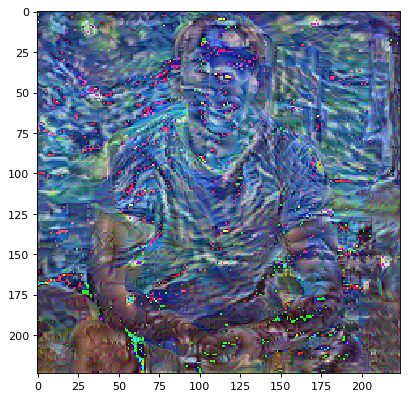

In [72]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 10, 3, torch.Tensor(result))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))